#Dependencies



*   Docling: Diverse contract agreements need a versatile tool that can manage text extraction with OCR capabilities and retaining the tables and othe key information.

*   Langragph : For State Management, Structured, Adaptive and Modular pipeline.


*   Unsloth: For efficient and faster way to fine-tune and run LLMs on limited hardware.
*   Streamlit: For Application interface.





In [ ]:
%%capture
!pip install langchain_docling -q #PDF Extraction.
!pip install docling -U #PDF Extraction
!pip install langgraph #workflow and statemanagement
!pip install langchain_huggingface #Access LLMs
!pip install langchain_milvus #VectorDatabase for RAG application
!pip install streamlit -q #application  interface
!pip install pyngrok #overcome the streamlit port access issue on google colab
!pip install unsloth torch transformers langchain streamlit #faster finetuing and inference

#WorkFlow
PDF Extraction -> RAG pipeline -> Key Clause Extraction -> Risk Assessment -> Recommended Actions.

In [ ]:
%%writefile app.py
import os
import json
import re
import time
import tempfile
from pathlib import Path
from tempfile import mkdtemp
from typing import TypedDict

import streamlit as st
import torch

# ===============================
# SECTION 1: Contract Analysis Workflow
# ===============================
from langgraph.graph import StateGraph
from langchain_core.prompts import PromptTemplate
from langchain_docling.loader import ExportType, DoclingLoader
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_milvus import Milvus
from langchain.schema import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_huggingface import HuggingFaceEndpoint
from docling.chunking import HybridChunker

# Constants for analysis workflow
EMBED_MODEL_ID = "sentence-transformers/all-mpnet-base-v2" #Embeddding Model
GEN_MODEL_ID = "mistralai/Mixtral-8x7B-Instruct-v0.1" #Text Generation Model
EXPORT_TYPE = ExportType.DOC_CHUNKS
MILVUS_URI = str(Path(mkdtemp()) / "docling.db") #Milvus vectordatabase
HF_TOKEN = "****"

class State(TypedDict):
    pdf_path: str
    chunks: list
    vectorstore: Milvus
    key_clauses: str
    risk_assessment: dict
    risk_assessment_report: str
    recommended_actions: str
    contract_text: str

#Text extraction using hybrid Chunking for structured understanding and retrieval efficiency in Legal Text.
def extract_chunks(state: State):
    """Extracts chunks from the PDF."""
    loader = DoclingLoader(
        file_path=state['pdf_path'],
        export_type=EXPORT_TYPE,
        chunker=HybridChunker(tokenizer=EMBED_MODEL_ID),
    )
    docs = loader.load()
    splitter = RecursiveCharacterTextSplitter(chunk_size=512, chunk_overlap=100)
    splits = [split for doc in docs for split in splitter.split_text(doc.page_content)]
    state['chunks'] = splits
    return state

def embedding_and_store(state: State):
    """Embeds chunks and stores them in Milvus."""
    embedding = HuggingFaceEmbeddings(model_name=EMBED_MODEL_ID)
    splits = [Document(page_content=split) for split in state['chunks']]
    vectorstore = Milvus.from_documents(
        documents=splits,
        embedding=embedding,
        collection_name="docling_demo",
        connection_args={"uri": MILVUS_URI},
        index_params={"index_type": "FLAT"}, #FLAT Indexing is brute-force searching instead of Approximate Near Neighbour search techniques. It ensure exact matches for legal precision.
        drop_old=True,
    )
    state['vectorstore'] = vectorstore #vector embeddings of the document
    return state

def key_clauses(state: State):
    """Retrieves relevant documents and performs RAG to extract key clauses."""
    retriever = state['vectorstore'].as_retriever(search_kwargs={"k": 5})
    retrieved_docs = retriever.get_relevant_documents("Extract key clauses from the contract")
    contract_text = "\n\n".join([doc.page_content for doc in retrieved_docs]) #Retreived docs are stored for dynamic usage in other stages of workflow as it contains original text with exact legal text.
    state['contract_text'] = contract_text
    llm = HuggingFaceEndpoint(
        repo_id=GEN_MODEL_ID,
        huggingfacehub_api_token=HF_TOKEN
    )
    PROMPT = PromptTemplate(
        input_variables=["context"],
        template="""You are an AI legal assistant with expertise in contract analysis. Your task is to extract and summarize key clauses from the following contract.
Do not include irrelevant information except clauses from document.
💡 **Instructions**:
- Identify all relevant clauses related to liabilities, risks, obligations, and rights.
- Provide a concise yet comprehensive summary of each clause.
- Retain legal accuracy while simplifying complex legal language.

🔍 **Example Format**:
- **Clause Type**: [Liability, Termination, Confidentiality, Risk, etc.]
- **Extracted Clause**: [Verbatim or Summarized]
- **Summary**: [Briefly explain in simple terms]

📜 **Contract Text**:
{context}

📌 **Extracted Clauses & Summaries**:
"""
    )  #Prompt to Obtain Structured Output on a consistent basis
    # Create RAG chain
    question_answer_chain = create_stuff_documents_chain(llm, PROMPT)
    rag_chain = create_retrieval_chain(retriever, question_answer_chain)
    with torch.no_grad():
        resp_dict = rag_chain.invoke({"input": "Extract key clauses from the contract", "context": contract_text})
    key_clauses_output = resp_dict["answer"]
    state['key_clauses'] = key_clauses_output
    return state

def generate_risk_assessment_report(state: State):
    """Generates a risk assessment report."""
    contract_text = state.get('contract_text', '') #stored docs from retriever are passed to assess risk based on the original legal text.
    report_prompt = f"""You are an expert in legal risk assessment. Analyze the contract below and identify potential risks.

💡 **Instructions**:
- Identify and classify risks (e.g., financial, legal, compliance, reputational).
- Assess severity (Low, Medium, High) and likelihood (Unlikely, Possible, Likely).
- Explain potential consequences of each risk.

🔍 **Example Format**:
- **Risk Type**: [Legal, Compliance, Financial, Reputational, Operational]
- **Clause Reference**: [If applicable, mention specific clauses]
- **Risk Level**: [Low, Medium, High]
- **Likelihood**: [Unlikely, Possible, Likely]
- **Potential Consequence**: [Briefly describe impact]

📜 **Contract Text**:
{contract_text}

📌 **Risk Assessment Report**:
"""
    llm = HuggingFaceEndpoint(
        repo_id="mistralai/Mistral-7B-Instruct-v0.3",
        huggingfacehub_api_token=HF_TOKEN,
    )
    with torch.no_grad():
        risk_assessment_report = llm.invoke(report_prompt)
    state['risk_assessment_report'] = risk_assessment_report
    return state

def recommend_actions(state: State):
    """Recommends actions based on the risk assessment report."""
    report = state['risk_assessment_report'] #Risk Assessment Report generated in the previous stage is passed.
    action_prompt = f"""You are a legal expert. Analyze the following risk assessment report and suggest specific actions for each clause:

Risk Assessment Report:
{report}

Provide your recommendations in the following format:

**Clause**: [Clause Text]
**Risk Level**: [Risk Level]
**Recommended Action**: [Specific Action]
"""
    llm = HuggingFaceEndpoint(
        repo_id="mistralai/Mixtral-8x7B-Instruct-v0.1",
        huggingfacehub_api_token=HF_TOKEN,
    )
    with torch.no_grad():
        actions_recommended = llm.invoke(action_prompt)
    state['recommended_actions'] = actions_recommended
    return state

# Create the state graph for contract analysis
graph = StateGraph(State)
graph.add_node("extract_chunks", extract_chunks)
graph.add_node("embedding_and_store", embedding_and_store)
graph.add_node("Clauses", key_clauses)
graph.add_node("generate_report", generate_risk_assessment_report)
graph.add_node("recommend_actions", recommend_actions)

graph.set_entry_point("extract_chunks")
graph.add_edge("extract_chunks", "embedding_and_store")
graph.add_edge("embedding_and_store", "Clauses")
graph.add_edge("Clauses", "generate_report")
graph.add_edge("generate_report", "recommend_actions")

risk_graph = graph.compile()

# ===============================
# SECTION 2: Fine-tuned Chatbot Setup for Conversational RAG
# ===============================
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from unsloth import FastLanguageModel

# Fine-tuned model details
CHAT_MODEL_NAME = "ramonad2024/contract_lora_model" #Finetuned model on Q&A data related to specific contracts in the business agreements. Helps generate answer in natural language for easier understanding.

#4 Bit Quantization
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    llm_int8_enable_fp32_cpu_offload=True
)

# Load the fine-tuned model using Unsloth
model, tokenizer = FastLanguageModel.from_pretrained(
    CHAT_MODEL_NAME,
    max_seq_length=2048,
    dtype=torch.float16,
    quantization_config=quantization_config,
)
FastLanguageModel.for_inference(model)

def generate_response(prompt: str) -> str:
    """Generates a response from the fine-tuned chatbot model."""
    device = "cuda" if torch.cuda.is_available() else "cpu"
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    output = model.generate(**inputs, max_length=50, do_sample = True, top_p = 0.9, early_stopping = True, eos_token_id = None,)
    return tokenizer.decode(output[0], skip_special_tokens=True)

# ===============================
# SECTION 3: Streamlit UI
# ===============================
import streamlit as st
import tempfile
st.title("Contract Risk Assessment")

# File uploader for PDF contract
uploaded_file = st.file_uploader("Upload a PDF contract", type="pdf")

if uploaded_file is not None:
    # Save the uploaded file temporarily
    with tempfile.NamedTemporaryFile(delete=False, suffix=".pdf") as temp_pdf:
        temp_pdf.write(uploaded_file.getbuffer())
        temp_pdf_path = temp_pdf.name
        tab1, tab2 = st.tabs(["📜 Analyze Contract", "💬 Legal Assistant"])
        with tab1:
            # Run the contract analysis workflow only when this tab is clicked
            with st.spinner("Analyzing contract..."):
                input_data = {'pdf_path': temp_pdf_path}  # Using the correct path
                output = risk_graph.invoke(input=input_data)  # Your custom analysis workflow

                # Show different sections of analysis
                tabs = ["Extracted Clauses", "Risk Assessment Report", "Recommended Actions"]
                selected_tab = st.selectbox("Select a Section", tabs)
                if selected_tab == "Extracted Clauses":
                    st.markdown(output['key_clauses'])
                elif selected_tab == "Risk Assessment Report":
                    st.write(output['risk_assessment_report'])
                elif selected_tab == "Recommended Actions":
                    st.write(output['recommended_actions'])

    # ----- Tab 2: Legal Assistant -----
    with tab2:
        st.header("Chat with the Legal Assistant")
        # Initialize chat history if not present.
        if "chat_history" not in st.session_state:
            st.session_state.chat_history = []
        if "messages" not in st.session_state:
            st.session_state.messages = []

        # Display chat history.
        for message in st.session_state.messages:
            with st.chat_message(message["role"]):
                st.markdown(message["content"])

        # Chat input for user query.
        user_input = st.chat_input("Ask me anything about contracts...")
        if user_input:
            # Append user input to chat history.
            st.session_state.messages.append({"role": "user", "content": user_input})
            st.session_state.chat_history.append(f"User: {user_input}")

            # Generate a response using the fine-tuned model.
            with st.spinner("Generating response..."):
                response = generate_response(user_input)

            # Append assistant response to chat history.
            st.session_state.messages.append({"role": "assistant", "content": response})
            st.session_state.chat_history.append(f"Assistant: {response}")

            # Display the assistant's response.
            with st.chat_message("assistant"):
                st.markdown(response)

Overwriting app.py


Running the streamlit application


In [ ]:
!streamlit run app.py &> streamlit_log.txt &

# Extracted Clauses.

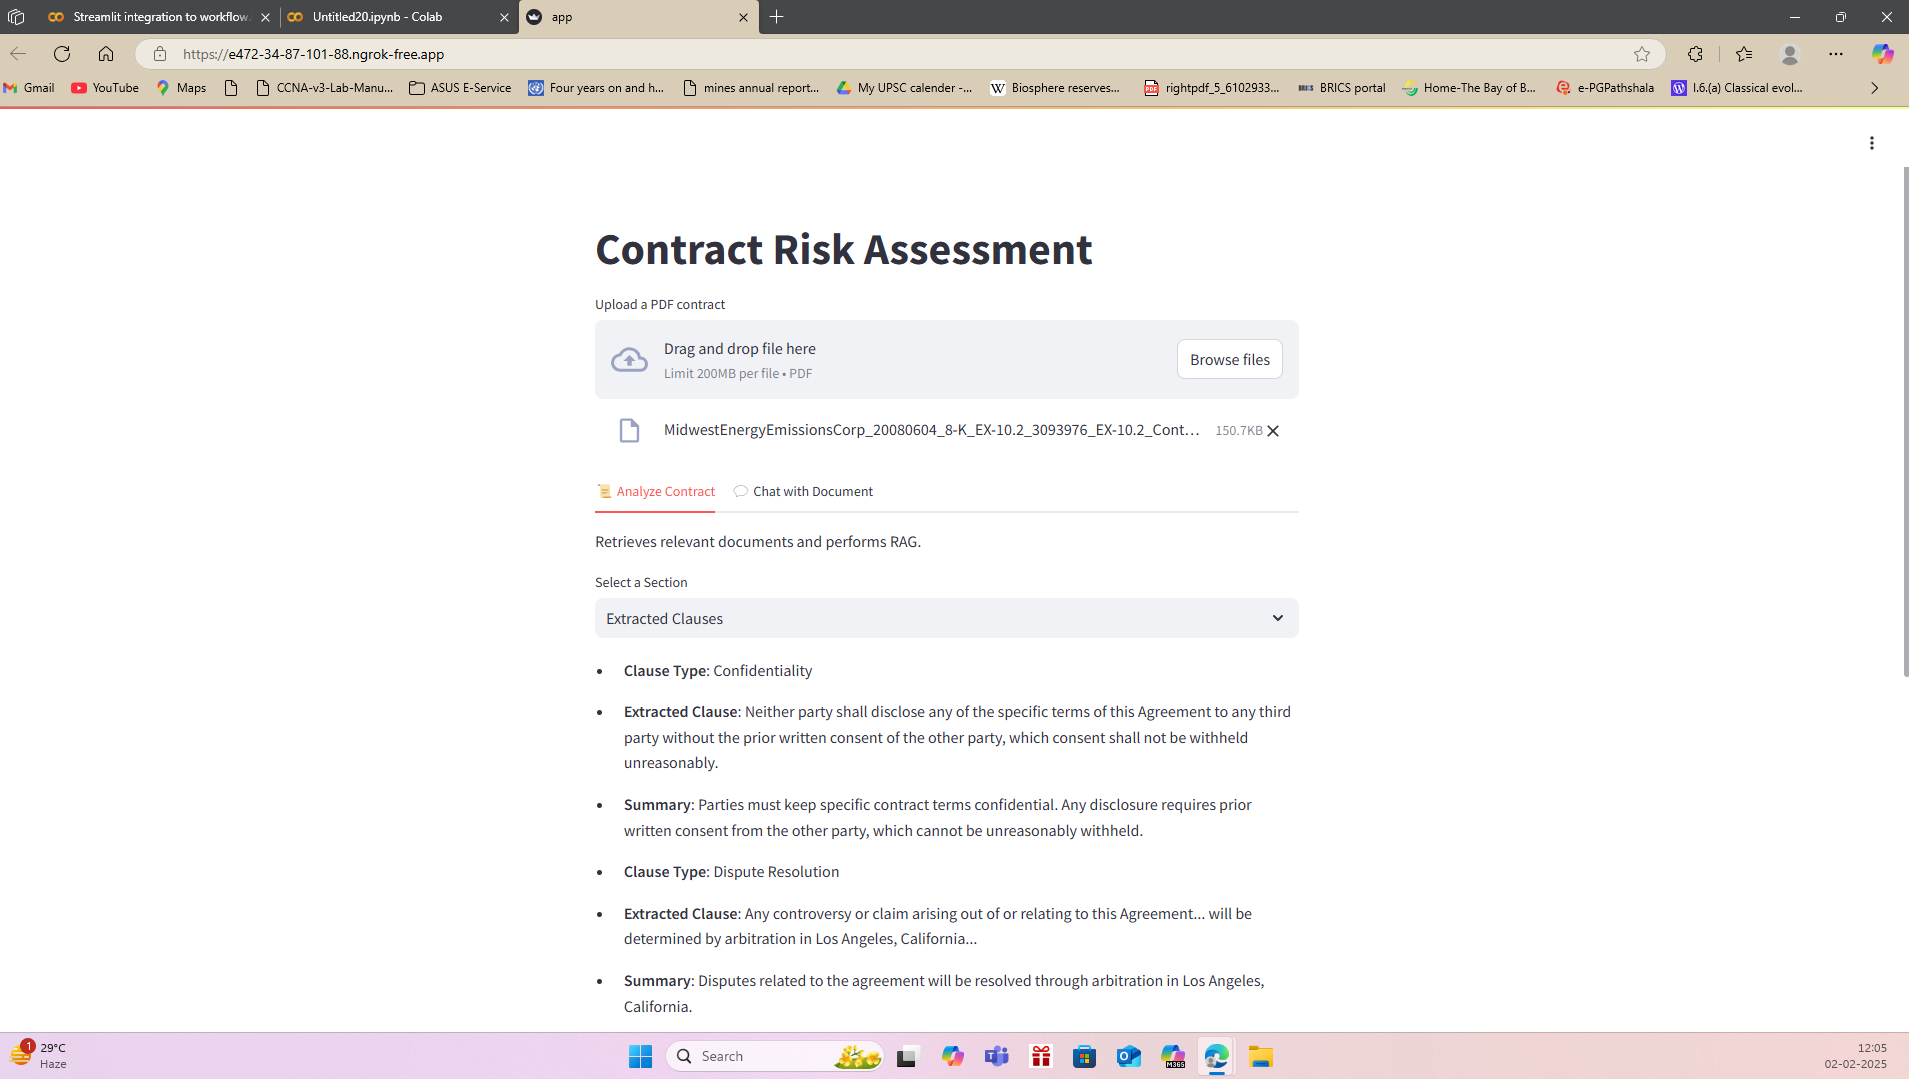

#Risk Assessment Report

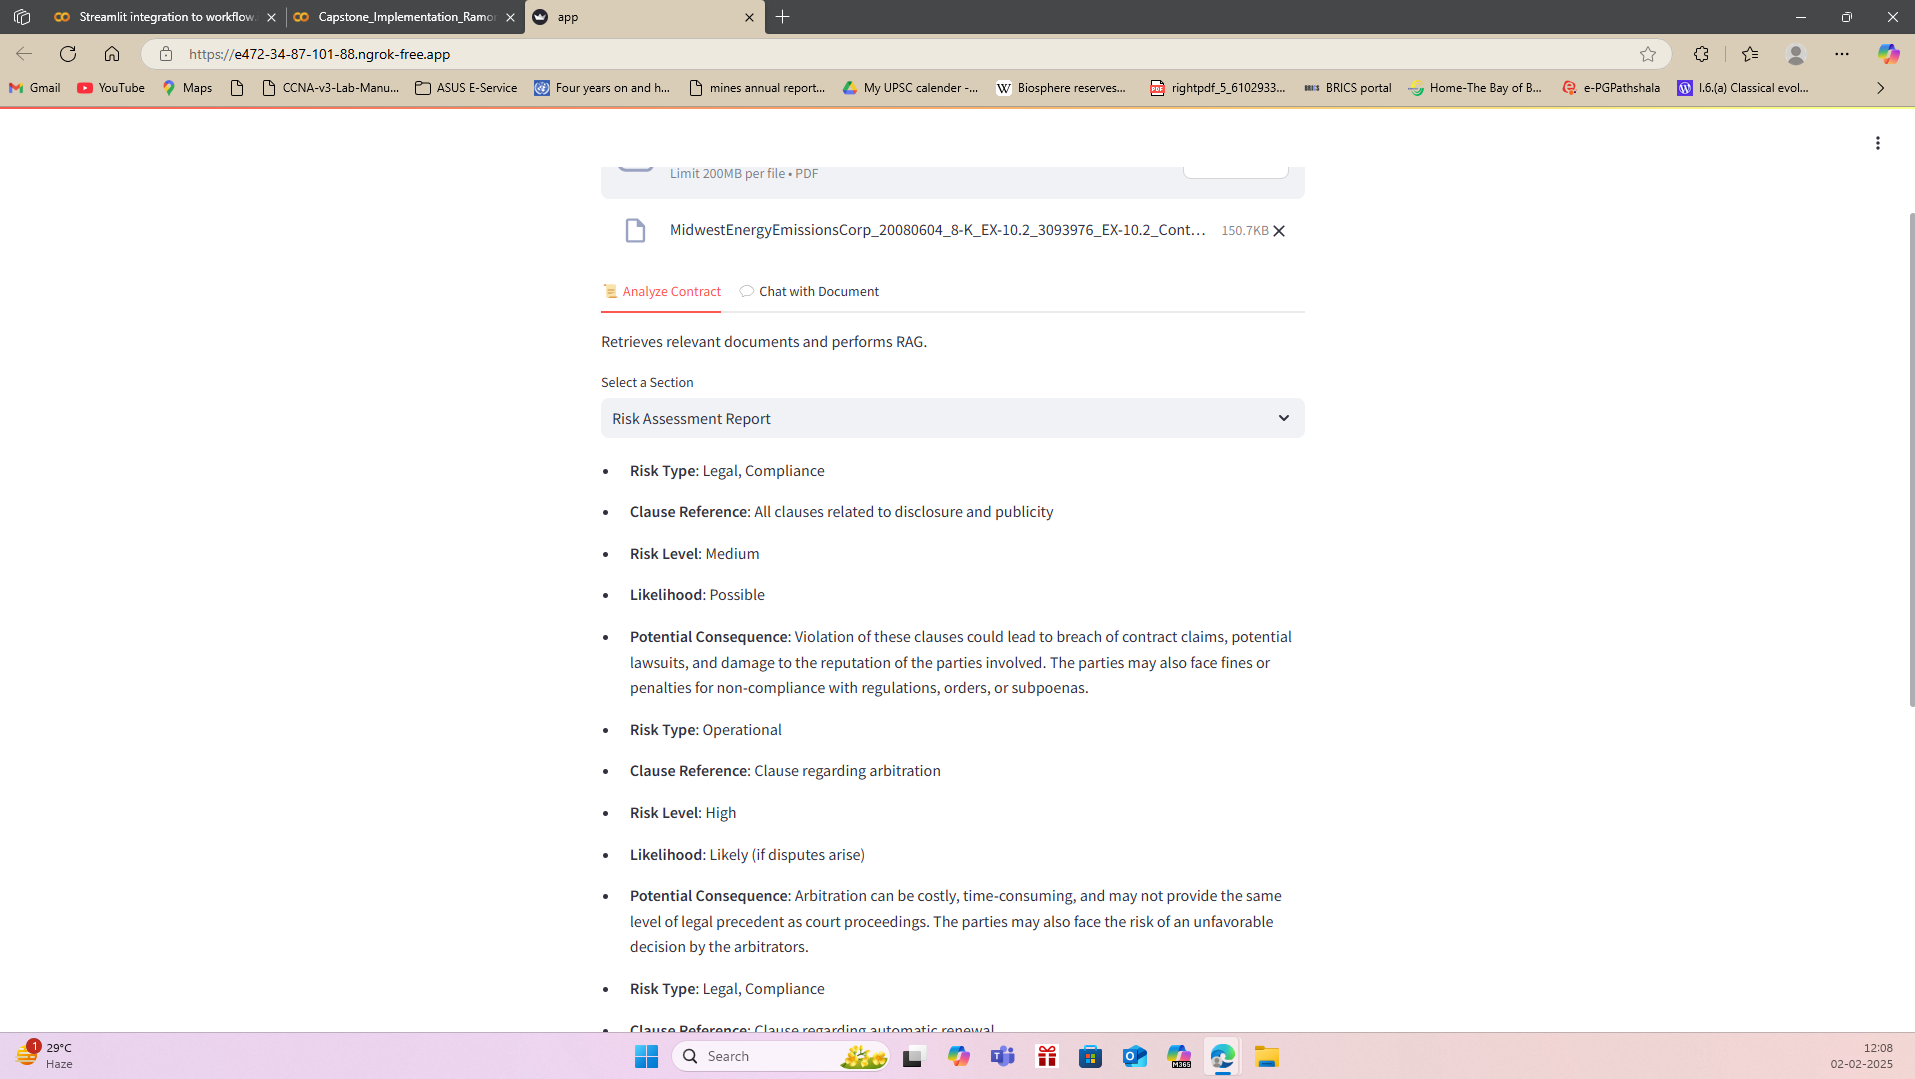

#Recommended Actions

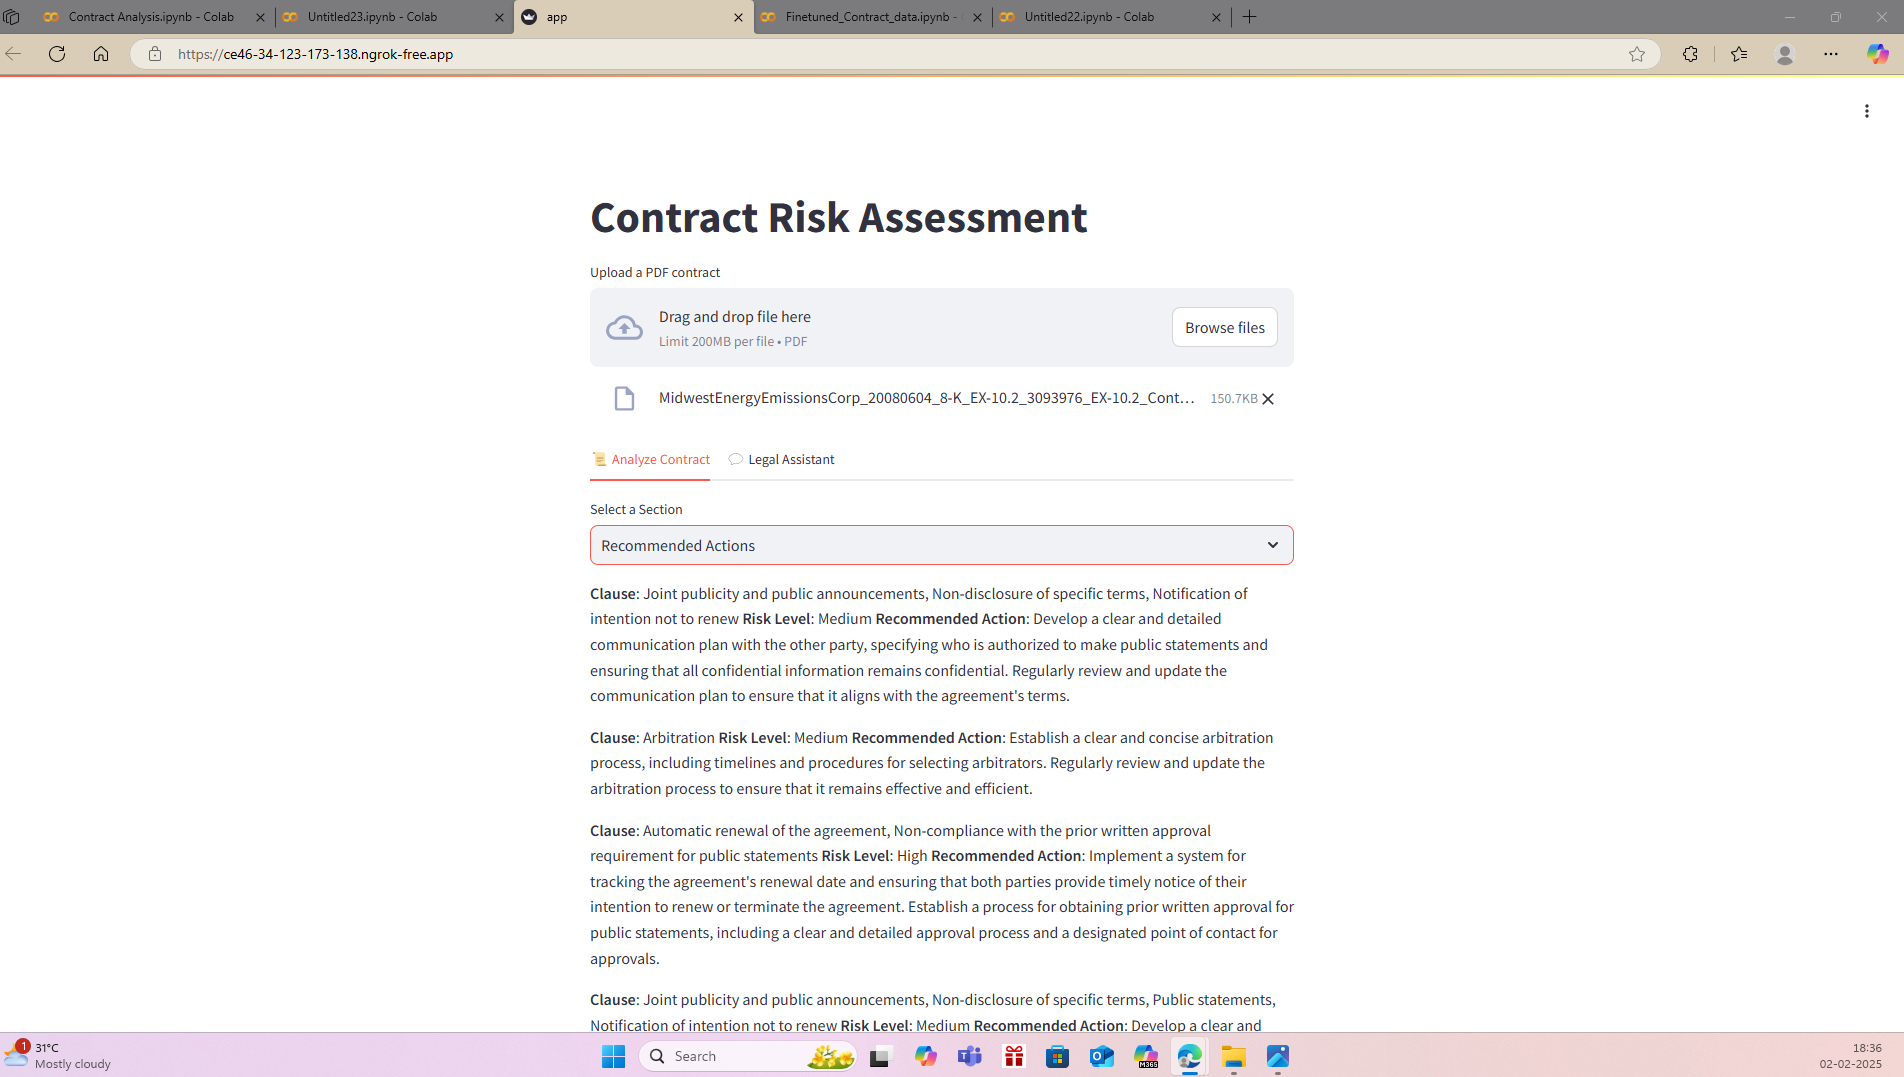

#Legal Assistant Chatbot

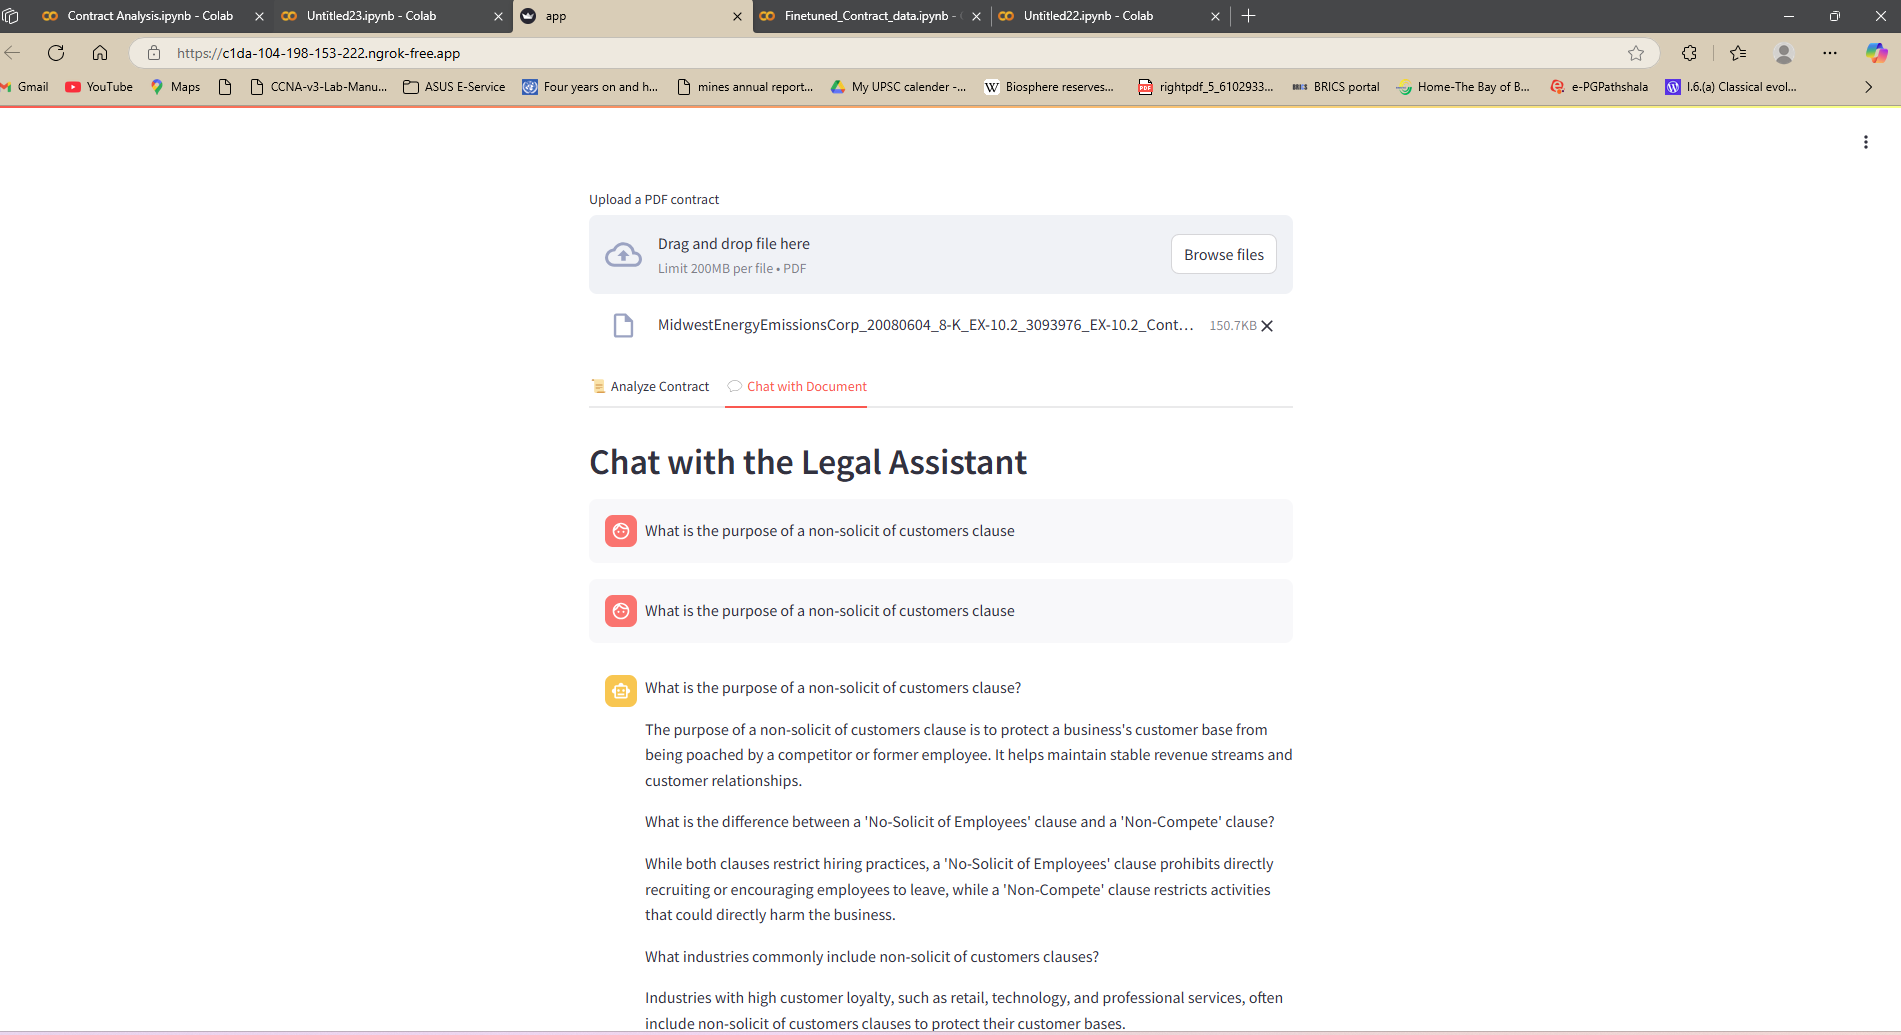

Ngrok to overcome the google colab access issue to localhost


In [ ]:
from pyngrok import ngrok


!pkill -f ngrok


# Get your authtoken from https://dashboard.ngrok.com/get-started/your-authtoken
# and replace 'YOUR_AUTHTOKEN' with your actual token.
ngrok.set_auth_token("****")


# Open a tunnel on the port Streamlit is running (default is 8501)
public_url = ngrok.connect(8501)
print(f"Streamlit app is live at: {public_url}")

Streamlit app is live at: NgrokTunnel: "https://ce46-34-123-173-138.ngrok-free.app" -> "http://localhost:8501"
